In [15]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from pathlib import Path
import scipy

%matplotlib widget 
from IPython.display import HTML
HTML('''<style>.jupyter-matplotlib {background-color: #000;}.widget-label{color: #fff;}.jupyter-matplotlib-header{color: #000!important;}.jupyter-button {background-color: #333;color: #fff;}.cell-output-ipywidget-background {background-color:#000!important;}</style>''')

In [3]:
SAMPLE_RATE = 44100

raw_samples_path = Path('dataset/raw')

for recording_path in raw_samples_path.glob("*.wav"):
    print(recording_path.stem)

kck0
kck1
kck2
kck3
snr0
snr1
snr2
snr3


In [18]:
def split_recording(recording_path, threshold=0.001):
	sample_rate, wave = scipy.io.wavfile.read(recording_path)
	if(sample_rate != SAMPLE_RATE):
		wave = scipy.signal.resample(wave, int(len(wave) * SAMPLE_RATE / sample_rate))
		print("resampled")

	if len(wave.shape) > 1:
		wave = wave.mean(axis=1)

	start_index = np.argmax(wave > threshold)
	wave = wave[start_index:]
	return wave

In [19]:
def high_pass(wave, cutoff_f=1000):
	order = 2

	highpass_iir = scipy.signal.iirfilter(
		order, [cutoff_f], btype='highpass',
		analog=False, ftype='butter', fs=SAMPLE_RATE,
		output='ba'
	)

	return scipy.signal.filtfilt(*highpass_iir, wave)


def find_onsets(
		wave: np.ndarray,
		min_threshold: float = 0.001, 
		dynamic_threshold_coeff: float = 2.0, 
		kernel_size: int = 2000,
		min_time_between_onsets: float = 0.05 # s
):
	wave_abs = np.abs(wave)
	wave_avg = (np.convolve(wave_abs, [1]*kernel_size)/kernel_size)[:len(wave)]
	dynamic_threshold = wave_avg * dynamic_threshold_coeff

	beats = np.where(wave_abs > np.maximum(dynamic_threshold, min_threshold), 1, 0)
	onsets: list[int] = []

	# remove beats that are too close to each other
	min_samples_between_onsets = int(min_time_between_onsets * SAMPLE_RATE)
	for i in range(len(beats)):
		if beats[i] > 0:
			beats[i+1:i+min_samples_between_onsets] = 0

	# find onsets
	for i in range(len(beats)):
		if beats[i] > 0:
			onsets.append(i)

	return onsets, dynamic_threshold

C:\Users\jezersek\AppData\Local\Temp\ipykernel_369112\2571407256.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, wave = scipy.io.wavfile.read(path)


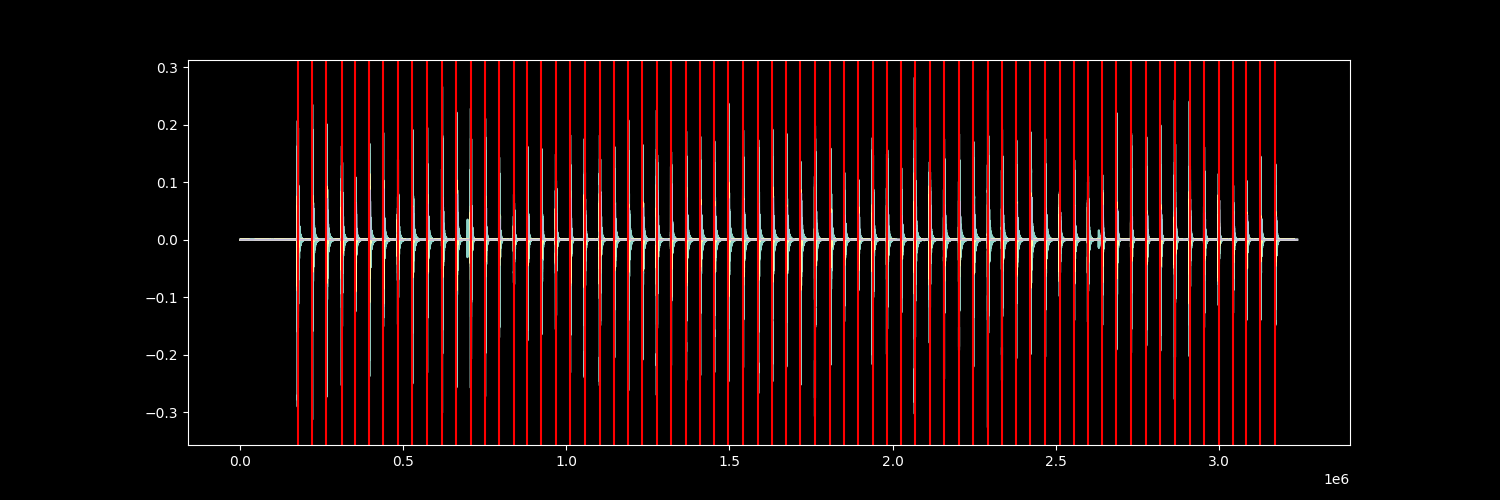

In [20]:
path = raw_samples_path / "snr3.wav"
sample_rate, wave = scipy.io.wavfile.read(path)
wave = wave.mean(axis=1)
high_pass_wave = high_pass(wave, cutoff_f=500)
onsets, dynamic_threshold = find_onsets(wave, min_threshold=0.005, dynamic_threshold_coeff=2.0, kernel_size=2000, min_time_between_onsets=1/30)
high_onsets, high_dynamic_threshold = find_onsets(high_pass_wave, min_threshold=0.005, dynamic_threshold_coeff=5.0, kernel_size=2000, min_time_between_onsets=1/30)

plt.figure(figsize=(15, 5))
plt.plot(wave)
plt.plot(high_pass_wave)
plt.plot(high_dynamic_threshold)


samples = []

result_path = raw_samples_path / path.stem
result_path.mkdir(parents=True, exist_ok=True)

for n, onset in enumerate(high_onsets):
	plt.axvline(onset, color='r')
	i = onset# - 100
	sample = wave[i:i+int(0.8*SAMPLE_RATE)]	

	scipy.io.wavfile.write(result_path / f"{n}.wav", SAMPLE_RATE, sample)
	samples.append(sample)


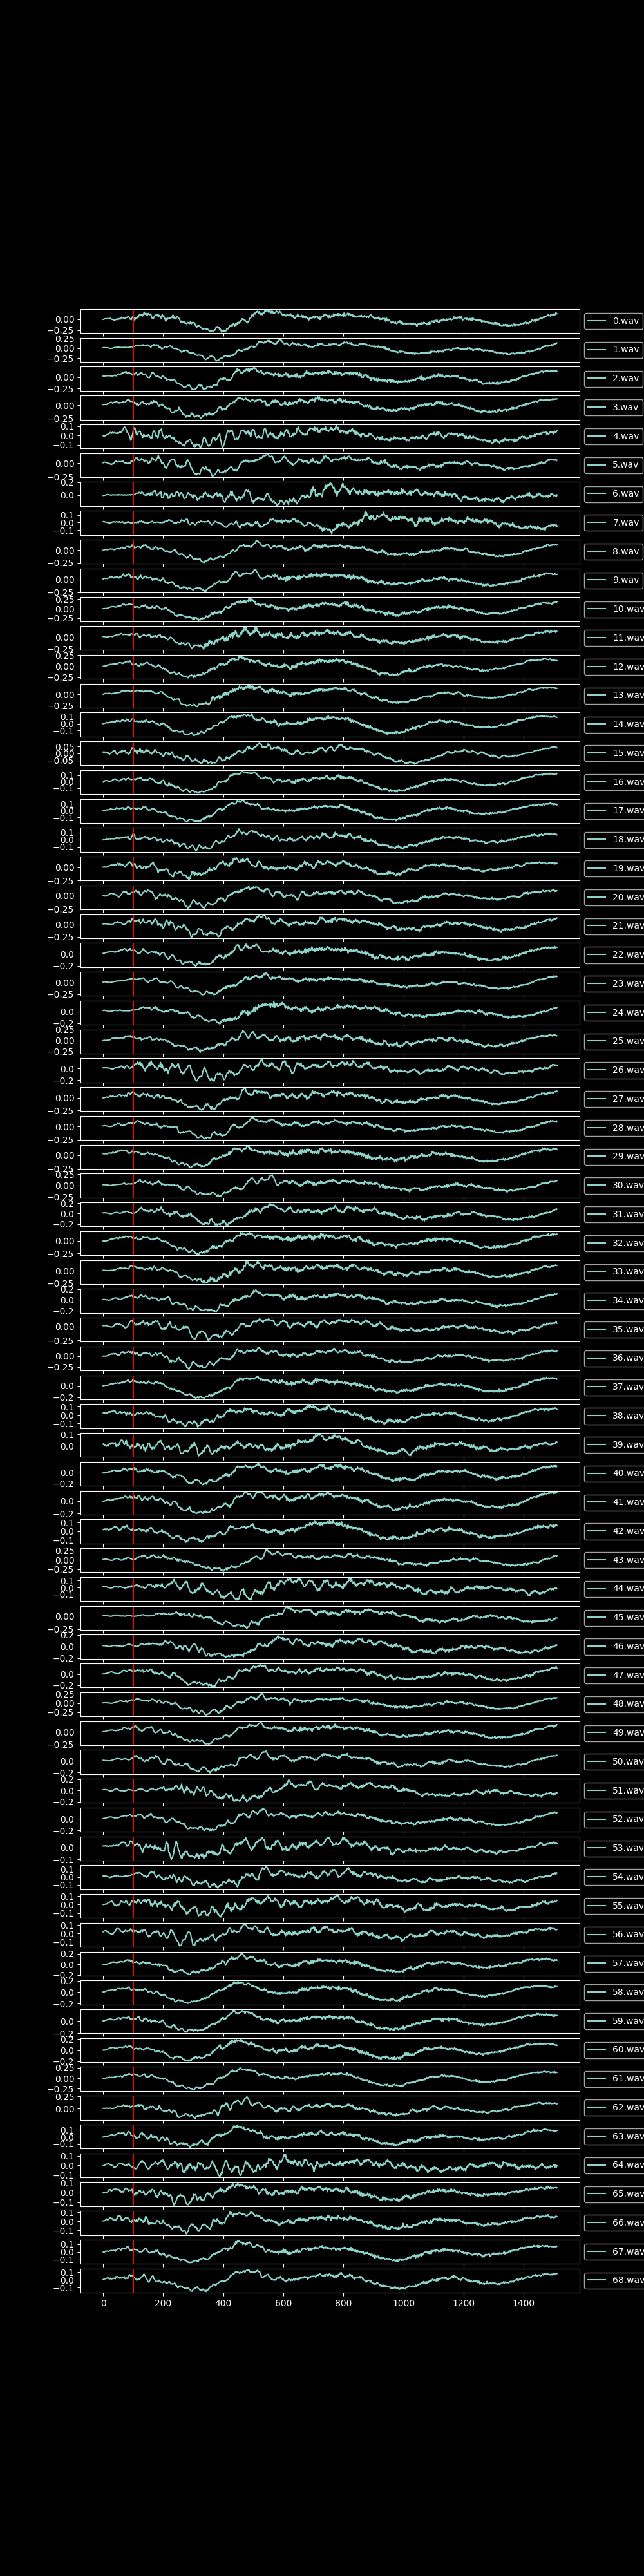

In [21]:
# display some kicks
window_size = 1512
N = len(samples)
plt.figure(figsize=(10, 40))
for i, sample in enumerate(samples):
	plt.subplot(N, 1, i+1)
	plt.plot(sample[:window_size], label=f"{i}.wav")
	plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))	
	plt.axvline(100, color='r')


In [40]:
Audio(samples[20], rate=sample_rate)

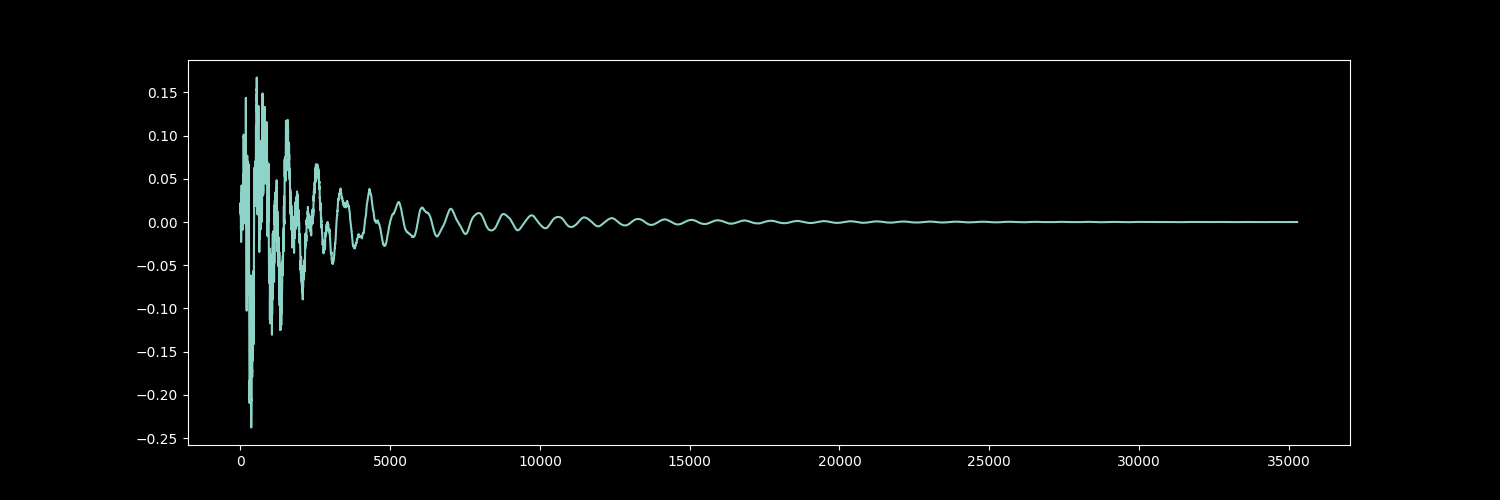

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(samples[5])

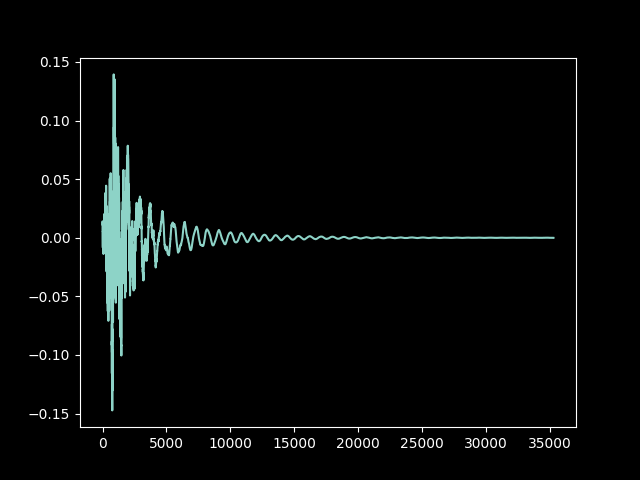

In [33]:
sample_rate, wave = scipy.io.wavfile.read(raw_samples_path / "snr3/7.wav")
plt.figure()
plt.plot(wave)